In [0]:
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import TruncatedSVD

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from prettytable import PrettyTable

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud

# Import the data

In [8]:
import pandas as pd
final = pd.read_csv("grouped_data_200.csv")
p = final.groupby('Score')
pos = p.get_group('Positive') #Gets the groups with Positive score
neg = p.get_group('Negative') #Gets the groups with Negative score
pos_2000 = pos.sample(60000) #Gets 60000 reviews of positive and 40000 negative scores
neg_2000 = neg.sample(40000)
grouped_data = pd.concat([pos_2000, neg_2000], ignore_index = True) #This data now contains positive and negative data in order.
grouped_data.dropna(inplace = True) #Drops rows with Nan
grouped_data.reset_index(inplace=True) #Replaces missing indexes
grouped_data.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Score'], axis=1, inplace=True)
grouped_data = grouped_data.sort_values('Time', axis=0, ascending=True, kind='quicksort')
print("The shape of grouped data is {}".format(grouped_data.shape))

The shape of grouped data is (99994, 11)


# TFIDF Vectorization

In [0]:
tf_idf_vect = TfidfVectorizer()
vocab_tf_idf = tf_idf_vect.fit_transform(grouped_data['CleanedText'].values.astype('U')) #Converts to a sparse matrix of TF-IDF vectors.

**Observations:** Perform TF-IDF Vectorization on whole data.

In [0]:
idf = tf_idf_vect.idf_ #Gets the idf scores of each feature
features = tf_idf_vect.get_feature_names() #Gets the feature names

**Observations:** Gets the idf values and features of the corpus.

In [11]:
def top_tfidf(idf, features, top_n): #Function to get top words based on idf values
    top_ids = np.argsort(idf)[:top_n] #Gets the indices of least n idf values
    words = [features[i] for i in top_ids] #Gets the corresponding feature and stores it in a list
    return words

words = top_tfidf(idf, features, 2000)
len(words)

2000

**Observations:** Top 2000 words are taken and stored in a list.

In [32]:
print("Top 5 words in the corpus are",words[:5])

Top 5 words in the corpus are ['like', 'tast', 'good', 'product', 'one']


In [12]:
list_of_sent = []
for sent in grouped_data['CleanedText'].values: #A review is selected from each row
    list_of_sent.append([w for w in sent.split()]) #All the sentences are appended into a single list
    
print('Total number of reviews appended into a list are',len(list_of_sent))

Total number of reviews appended into a list are 99994


**Observations:** All the reviews are taken and appended into a single list.

# Co-occurance matrix

In [0]:
co_occ = np.zeros([len(words),len(words)]) #Create a matrix with zeros of size length of top words which is 2000
for sent in list_of_sent: #Select a sentence from the list of all appended sentences
    for index, word in enumerate(sent): #For a word and its index in the sentence
        if word in words: #If the word exists in list of top words
            for i in range(1,7): #It iterates through a window of 6 words ahead of it
                try:
                    nxt_word = sent[index+i] #Set next word as the word next to it
                except:
                    break #Terminate upon reaching the last word
                if nxt_word in words: #If the next word exists in lost of top words
                    if nxt_word==word: #Don't consider next word of its the same word as initial word
                        continue
                    else:
                        co_occ[words.index(word),words.index(nxt_word)]+=1 #Increment the co occurance matrix position
            for i in range(1,7): #It iterates through a window of 6 words behind it
                if index-i<0: #Will terminate the loop if it reaches the first word in the list
                    break
                else: 
                    prv_word = sent[index-i] #Set the previous word
                    if prv_word in words: #If the previous word exists in the list of top words
                        if prv_word==word: #Don't consider if this word is same same as initial word
                            continue
                        else:
                            co_occ[words.index(word),words.index(prv_word)]+=1 #Increment the co occurance matrix position

**Observations:** A co occurance matrix of size 2000 * 2000 is constructed here. We prefer a window size of 5. 

In [14]:
print("It is {} that the co-occurance matrix is symmetric and of size {}.".format(np.allclose(co_occ, co_occ.T, atol=1e-8), co_occ.shape))

It is True that the co-occurance matrix is symmetric and of size (2000, 2000).


# TruncatedSVD and KMeans

In [0]:
var_ratio = []
for i in range(100,2000,100): #Select n_components from 100 to 1900 with a step of 100
    svd = TruncatedSVD(n_components = i) #Perform TruncatedSVD on n_components
    data = svd.fit_transform(co_occ)
    var_ratio.append(svd.explained_variance_ratio_.sum()) #Get the explained variance ratio and append it into a list

**Observations:** Get the explained variance ratios of each n_component and store it in a list.

[]

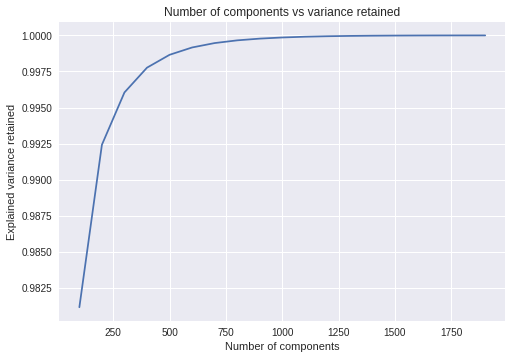

In [16]:
plt.figure()
plt.plot(list(range(100,2000,100)),var_ratio)
#for xy in zip(list(range(100,2000,100)), var_ratio):
    #plt.annotate('({})'.format(xy), xy=xy, textcoords='data')
plt.xlabel('Number of components')
plt.ylabel('Explained variance retained')
plt.title('Number of components vs variance retained')
plt.grid(linestyle='-')
plt.plot()

**Observations:** Plot of explained variance for each n_components.

In [17]:
for x,y in zip(list(range(100,2000,100)), var_ratio):
    print("For n_components = {}, the value of explained variance is {}.".format(x,y))

For n_components = 100, the value of explained variance is 0.9811537198680574.
For n_components = 200, the value of explained variance is 0.9924167994974915.
For n_components = 300, the value of explained variance is 0.9960457464258318.
For n_components = 400, the value of explained variance is 0.9977639085027308.
For n_components = 500, the value of explained variance is 0.9986548031318295.
For n_components = 600, the value of explained variance is 0.9991635104728602.
For n_components = 700, the value of explained variance is 0.999468847498763.
For n_components = 800, the value of explained variance is 0.9996569206782869.
For n_components = 900, the value of explained variance is 0.9997775995768053.
For n_components = 1000, the value of explained variance is 0.9998565383409378.
For n_components = 1100, the value of explained variance is 0.9999083661119913.
For n_components = 1200, the value of explained variance is 0.9999427060393181.
For n_components = 1300, the value of explained va

In [0]:
def input_k(): #This function is used to obtain K value from the user
    k = int(input("Enter the value of K observed in the above plot: "))
    return k

def plot_df_wordcloud(data,labels_list): #This function plots wordcloud and reviews from each cluster
    print('\n')
    print("Creating a dataframe with Words and Clusters...")
    
    amz = {'Words': words,'Clusters': labels_list} #Creating a dictionary with Reviews, Cleaned text and clusters
    df = pd.DataFrame(amz, columns=['Words', 'Clusters']) #Creating a dataframe of the above dictionary
    print("Dataframe is created!")
    print('\n')

    print("The number of words in each cluster is:")
    print(df['Clusters'].value_counts()) #Outputs the number of reviews in each cluster
    print('\n')
    print('*'*70)
    
    for i in range(min(labels_list),max(labels_list)+1): #Iterates through K and prints wordcloud and reviews for all the clusters
        print('\n')
        print('\n')
        print("*"*40,'Cluster ',i,"*"*40)
        words_i=[] #Create an empty list to store words
        for word in df['Words'][df['Clusters']==i].values: #Splits sentences into words and stores it in a list
            words_i.append(word) #Appends the split words to above created list

        print('\n')
        print('Plot of Word Cloud')
        wordcloud1 = WordCloud().generate(" ".join(words_i)) #Initiate wordcloud for the list of words
        plt.figure() #Plots the wordcloud
        plt.imshow(wordcloud1)
        plt.axis("off")
        plt.show()

        count = df['Words'][df['Clusters']==i].count()
        if count//2>=9:#Prints random 5 words if the number of words in that cluster is more than 10
            print('\n')
            print('\n')
            print('Printing 5 random words from cluster',i)
            pd.set_option('display.max_colwidth', -1) #Displays full reviews
            print(df['Words'][df['Clusters']==i][count//2:count//2+5])
            print('\n')
            print('\n')
        else: #Prints random words if the number of words in that cluster is between 0 and 10
            print('\n')
            print('\n')
            print('Printing random words from cluster',i)
            pd.set_option('display.max_colwidth', -1) #Displays reviews in full length
            print(df['Words'][df['Clusters']==i][count//2:])
            print('\n')
            print('\n')

def k_means(data,std_data): #This function perform K means. The data frame and standardized vector forms of the reviews are given as input
    k=list(range(2,11)) #Considers K value between 1 and 10 (inclusive)
    inertia_list=[] #Gets the list of inertias for plotting the elbow curve
    silhou_list=[] #Gets the list of silhouette values for each k to plot a bar graph later
    clf = KMeans(n_clusters=1,n_init=60)
    clf.fit(std_data)
    inertia_list.append(clf.inertia_)
    for i in k: #Iterates through the K values and gets a list of inertia values for plotting later
        clf = KMeans(n_clusters=i,n_init=60)
        clf_labels = clf.fit_predict(std_data) #Gets labels for each data point
        inertia_list.append(clf.inertia_)
        clf_labels_list = clf_labels.tolist() #Convert ndarray into a list
        avg_silhou = silhouette_score(std_data,clf_labels) #Initialize silhouette score
        silhou_list.append(avg_silhou) #Append all the silhoutte scores into the list created above to plot later
        
    plt.figure(1) #Plots the elbow curve
    plt.plot(list(range(1,11)),inertia_list)
    plt.title('K vs loss')
    plt.xlabel('K')
    plt.ylabel('loss')
    plt.grid(linestyle='-')
    plt.show()
    
    plt.figure(2)
    plt.bar(k,silhou_list) #Plots the bar graph
    plt.title('K vs Average Silhouette Score')
    plt.xlabel('K')
    plt.ylabel('Average Silhouette Score')
    plt.show()


    k = input_k() #After looking at the elbow curve and bar graph, the user inputs the optimal value of K

    print('\n')
    print("Performing K means on K=",k)
    clf = KMeans(n_clusters=k, n_init=60) #Perform K means on the optimal K value input earlier
    clf.fit(std_data)
    labels_list = clf.labels_.tolist() #Getting the labels list to identify clusters
    print("Done!")
    plot_df_wordcloud(data,labels_list)

# Implement K means clustering for SVDS

In [19]:
from scipy.sparse.linalg import svds
U,sigma,V_T = svds(co_occ,k = 500) #svds gives the decomposed elements of SVD directly
print("The shape of word vector matrix after svds is",U.shape)

The shape of word vector matrix after svds is (2000, 500)


**Observations:** Used svds of scipy as a substitute to TruncatedSVD as it provides decomposed elements of SVD.

In [0]:
from sklearn.preprocessing import normalize
data = normalize(U)

**Observations:** Normalizing the data.

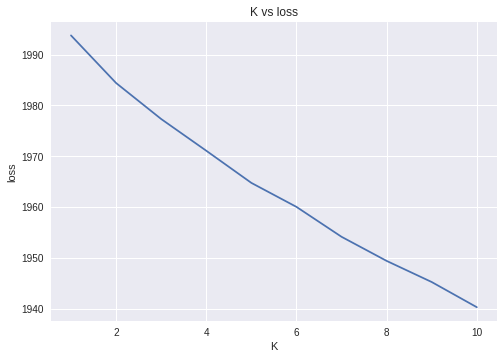

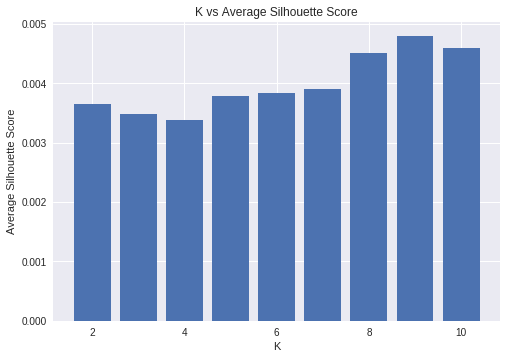

Enter the value of K observed in the above plot: 9


Performing K means on K= 9
Done!


Creating a dataframe with Words and Clusters...
Dataframe is created!


The number of words in each cluster is:
5    719
0    200
7    180
6    179
4    172
3    161
1    160
8    125
2    104
Name: Clusters, dtype: int64


**********************************************************************




**************************************** Cluster  0 ****************************************


Plot of Word Cloud


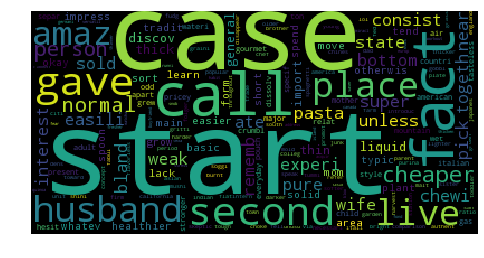





Printing 5 random words from cluster 0
1078    introduc
1091    burnt   
1111    via     
1120    tough   
1122    older   
Name: Words, dtype: object








**************************************** Cluster  1 ****************************************


Plot of Word Cloud


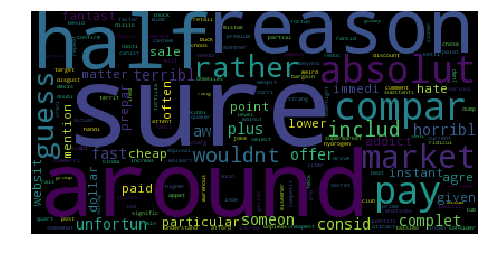





Printing 5 random words from cluster 1
990     prime   
994     despit  
996     walmart 
997     elsewher
1007    afford  
Name: Words, dtype: object








**************************************** Cluster  2 ****************************************


Plot of Word Cloud


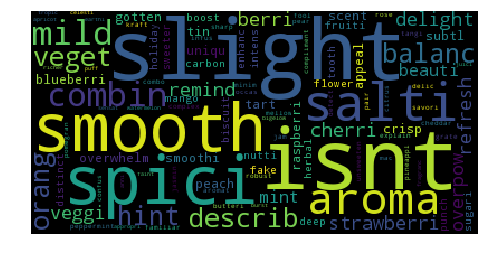





Printing 5 random words from cluster 2
1183    punch     
1205    sugari    
1237    herbal    
1260    enhanc    
1265    peppermint
Name: Words, dtype: object








**************************************** Cluster  3 ****************************************


Plot of Word Cloud


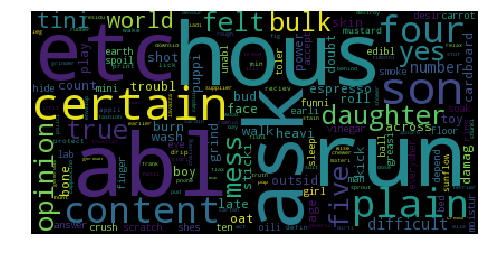





Printing 5 random words from cluster 3
1266    sleep 
1281    carrot
1296    man   
1312    floor 
1313    hide  
Name: Words, dtype: object








**************************************** Cluster  4 ****************************************


Plot of Word Cloud


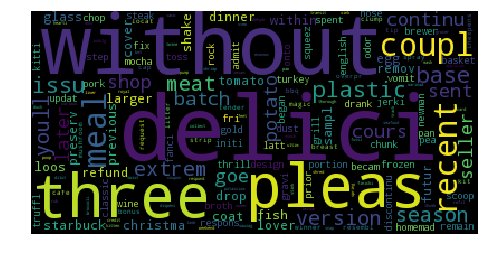





Printing 5 random words from cluster 4
1253    newman 
1257    classic
1262    chop   
1267    truffl 
1277    fanci  
Name: Words, dtype: object








**************************************** Cluster  5 ****************************************


Plot of Word Cloud


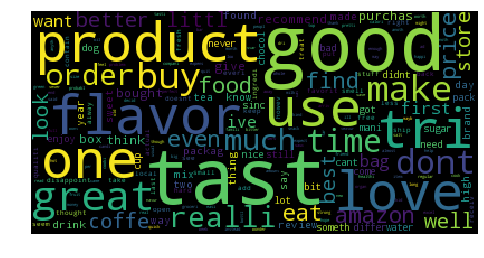





Printing 5 random words from cluster 5
488    grain 
491    except
492    follow
494    worst 
497    pop   
Name: Words, dtype: object








**************************************** Cluster  6 ****************************************


Plot of Word Cloud


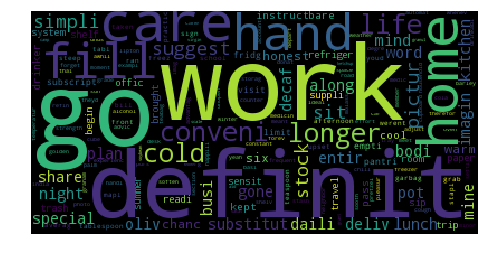





Printing 5 random words from cluster 6
1158    sign     
1159    experienc
1163    whenev   
1166    winter   
1189    freezer  
Name: Words, dtype: object








**************************************** Cluster  7 ****************************************


Plot of Word Cloud


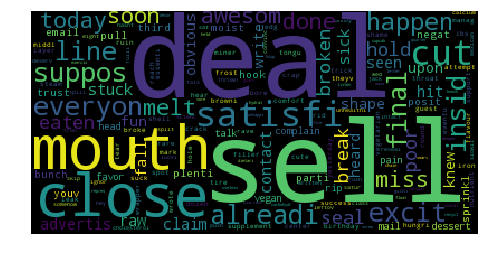





Printing 5 random words from cluster 7
1244    center
1245    browni
1248    hear  
1251    suck  
1261    theyv 
Name: Words, dtype: object








**************************************** Cluster  8 ****************************************


Plot of Word Cloud


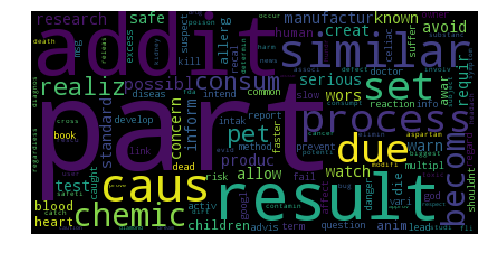





Printing 5 random words from cluster 8
1362    owner 
1377    info  
1386    excess
1401    googl 
1408    affect
Name: Words, dtype: object






In [21]:
k_means(words,data)

**Observations:** K value of 9 is observed to be more suitable. Wordcloud for each cluster is plotted above.

# Implement K means using Truncated SVD

In [22]:
svd = TruncatedSVD(n_components = 500)
co_occ_tsvd = svd.fit_transform(co_occ)
print("The shape of co occurance matrix after Truncated SVD is",co_occ_tsvd.shape)
print("The amount of variance retained is {}".format(svd.explained_variance_ratio_.sum()))

The shape of co occurance matrix after Truncated SVD is (2000, 500)
The amount of variance retained is 0.998654608860566


**Observations:** Performing TruncatedSVD on the co occurance matrix.

In [0]:
data = StandardScaler(with_mean=False).fit_transform(co_occ_tsvd)

**Observations:** Standardize the data.

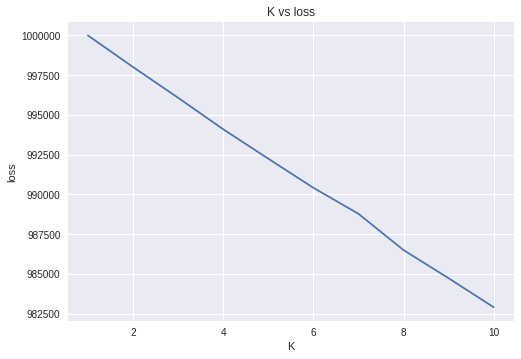

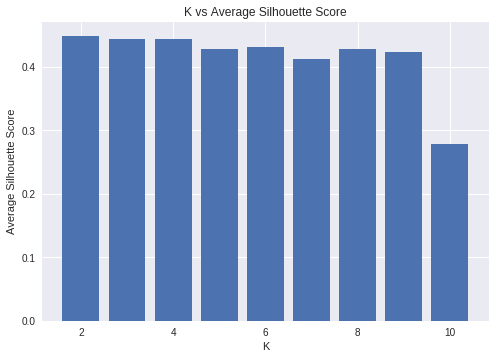

Enter the value of K observed in the above plot: 2


Performing K means on K= 2
Done!


Creating a dataframe with Words and Clusters...
Dataframe is created!


The number of words in each cluster is:
1    1999
0    1   
Name: Clusters, dtype: int64


**********************************************************************




**************************************** Cluster  0 ****************************************


Plot of Word Cloud


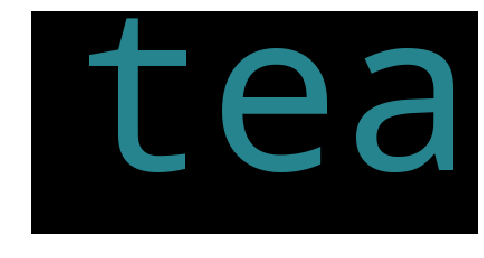





Printing random words from cluster 0
45    tea
Name: Words, dtype: object








**************************************** Cluster  1 ****************************************


Plot of Word Cloud


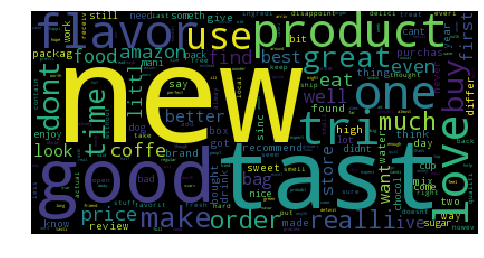





Printing 5 random words from cluster 1
1000    splenda
1001    refus  
1002    tree   
1003    child  
1004    mill   
Name: Words, dtype: object






In [24]:
k_means(words,data)

**Observations:** K value of 2 is found to be suitable. Wordcloud for corresponding clusters are plotted above.

# Cosine Similarity

In [0]:
from scipy.spatial.distance import cosine

def sim_words(word,n): #Computes cosine distance of the word with each word and returns most similar words
    try:
        sim_list = [(words[index],1-cosine(co_occ_tsvd[words.index(word),:],co_occ_tsvd[index,:])) for index in range(len(words))] #Creates a list of tuples containing a word and its corresponding cosine distance
        sim_list.sort(key=lambda x: x[1],reverse=True) #Sort the list in descending order based on cosine distances
        return sim_list[1:n+1] #Returns top n words except for the first as the first would be the query word itself
    except:
        print('{} not in the list.'.format(word)) #If word doesn't exist in the list it returns this

**Observations:** 

This function computes cosine distance of the query word with all the other words and returns the most similar words to it.

In [26]:
sim_words('like',5)

[('good', 0.9158262359778437),
 ('terribl', 0.9126084689086033),
 ('remind', 0.9113274334224933),
 ('okay', 0.9102400875027026),
 ('amaz', 0.9090859353015314)]

In [27]:
sim_words('dissapoint',5)

[('disappoint', 0.9549665819142389),
 ('unfortun', 0.9182722978074221),
 ('howev', 0.9109118798051474),
 ('impress', 0.9046679053868579),
 ('expect', 0.8929675669493691)]

In [28]:
sim_words('bring',5)

[('brought', 0.8755479729932736),
 ('come', 0.8550836798024557),
 ('go', 0.8424059563781426),
 ('memori', 0.8317744056338882),
 ('went', 0.8222653798021328)]

# Summary and Conclusions

1) 100k reviews are taken and TF-IDF is computed on those reviews.

2) Top 2000 words are selected based on their idf values.

3) Co occurance matrix is formed for each word.

4) Explained variance ratio values of TruncatedSVD on co occurance matrix is plotted for each n_component value and a value of 500 is selected. Scipy's SVDS is also computed for 500 components since it gives U, sigma and V_t.

5) K means clustering is done on SVDS and TruncatedSVD and clusters are visualized on a wordcloud. Since the elbow plot alone is not sufficient enough to get the best k sometimes, Silhouette score is also plotted to assist in selection of k value.

6) A function is created which computes cosine distances for the query word with every other word and returns the top words similar to it.